In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

The following lines need to be used if data the from downloaded dataset should be used. The location of the ``Data`` folder needs to be specified by the parameter ``DATA_FOLDER_PATH`` in the file ``input_params.json``. 

If you want to analyse your own dataset you need to set the variable ``file_path`` to the folder where the simulation is located. Importantly, in this folder there should only be located exactly one simulation.

In [10]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S3_homogeneous/Rescaled_Tc/not_blocked'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

parameter_path = os.path.join(file_path, 'parameter_set.csv')

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/parameter_set.csv


In [11]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

In [12]:
v_init_exp = 0.28
std_exp = 0.05

In [13]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/titration_vary_TC_60',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/variances_models.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/titration_vary_TC_50',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/CV_vary_TC.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/titration_vary_TC_40',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S3_homogeneous/Rescaled_Tc/not_blocked/CV_vary_TC_rescaled.pdf']


# Calculate CV

In [14]:
for simu_name in data_frame.simu_name.unique():
    simu_df = data_frame[data_frame["simu_name"] == simu_name]
    data_frame.loc[data_frame['simu_name'] == simu_name, 'mean_v_init_per_n_ori'] = np.mean(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'stdd_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'cv_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])/np.mean(simu_df["v_init_per_n_ori"])

# Calculate variance at different growth rates

In [15]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def calculate_CV_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.std(v_init_np[10:])/np.mean(v_init_np[10:])

In [23]:
data_frame["CV_v_init"] = data_frame.apply(lambda row: calculate_CV_v_init(row), axis=1)

/home/berger/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/berger/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/berger/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/berger/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/berger/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Rescale Tc period

In [17]:
def normalized_rate_growth(rate_growth, t_C):
#     print(t_C)
    return rate_growth / (np.log(2)/ t_C)


data_frame.loc[:, 'normalized_rate_growth'] = data_frame.apply(lambda row: normalized_rate_growth(row.rate_growth, row.t_C), axis = 1)


# Make legend

In [24]:
def make_legend(t_C):
    return r'$T_{{C}}={}$ min'.format(int(np.round(t_C*60,0)))

data_frame.loc[:, 'legend_TC'] = data_frame.apply(lambda row: make_legend(row.t_C), axis = 1)

# Plot amplitude time varying

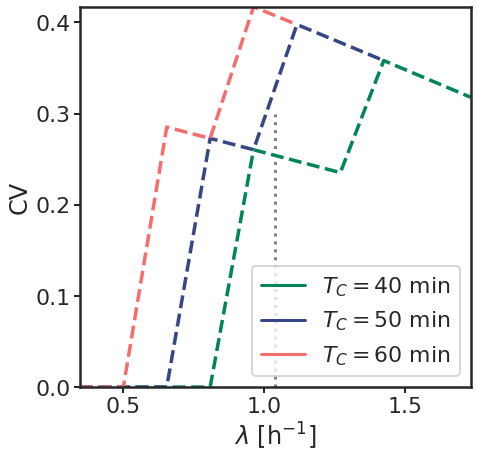

In [25]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
sns.lineplot(
    x='rate_growth', 
    y='CV_v_init',
    data=data_frame.sort_values(by=["t_C"]),
    hue='legend_TC',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
    markers=True,
    palette= [green, blue, pinkish_red],
    linewidth = 3.5,
    ax=ax
);
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
ax.margins(0)
ax.set(xlabel=r'$\lambda$ [h$^{-1}$]', ylabel=r'CV')
# plt.legend(labels=legend
# ax.set(ylim=(0,0.36))
ax.vlines(x=(np.log(2)/(40/60)), ymin=0, ymax=0.3, color='grey', linestyle='dotted')
# ax.set(ylim=(0,0.45))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/CV_vary_TC.pdf', format='pdf', bbox_inches='tight')

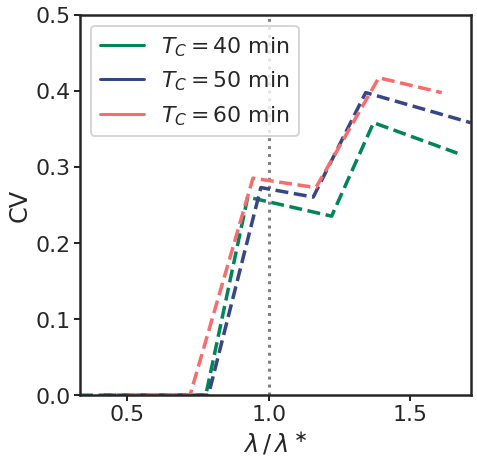

In [22]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
sns.lineplot(
    x='normalized_rate_growth', 
    y='CV_v_init',
    data=data_frame.sort_values(by=["t_C"]),
    hue='legend_TC',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
    markers=True,
    palette= [green, blue, pinkish_red],
    linewidth = 3.5,
    ax=ax
);
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
ax.margins(0)
ax.set(xlabel=r'$\lambda \, / \, \lambda^\ast$', ylabel=r'CV')
ax.vlines(x=1, ymin=0, ymax=0.5, color='grey', linestyle='dotted')
# ax.set(ylim=(0,0.3))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/CV_vary_TC_rescaled.pdf', format='pdf', bbox_inches='tight')